In [2]:
%reload_ext autoreload
%autoreload 2

In [213]:
from ripple_heterogeneity.utils import (
    functions,
    loading,
    batch_analysis,
    add_new_deep_sup,
)
from scipy import stats

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nelpy as nel
# import nelpy.plotting as npl
from matplotlib.ticker import AutoMinorLocator
import os
from scipy import stats
from statannot import add_stat_annotation
from scipy.ndimage import gaussian_filter1d

functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

In [11]:
df = pd.read_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv", index_col=0)
df = df[df.basepath.str.contains("ORproject")]
df

,basepath,basename
Var1,,
212,Z:\Data\ORproject\OR15\day1,day1
213,Z:\Data\ORproject\OR15\day10,day10
214,Z:\Data\ORproject\OR15\day2,day2
215,Z:\Data\ORproject\OR15\day3,day3
216,Z:\Data\ORproject\OR15\day4,day4
217,Z:\Data\ORproject\OR18\day1,day1
218,Z:\Data\ORproject\OR18\day2,day2
219,Z:\Data\ORproject\OR18\day3,day3
220,Z:\Data\ORproject\OR21\day2,day2


In [188]:
# basepath = [r"Z:\Data\ORproject\OR15\hc300118", r"\Data\ORproject\OR15\hc280118"]
results = pd.DataFrame()

for basepath in df.basepath:

    manipulation_epochs = loading.load_manipulation(
        basepath, struct_name="optoStim", return_epoch_array=False
    )
    st, cm = loading.load_spikes(basepath, putativeCellType="Pyr", brainRegion="CA1")
    cm = add_new_deep_sup.deep_sup_from_deepSuperficialDistance(cm)

    closed_loop = functions.get_participation(
        st.data,
        manipulation_epochs[manipulation_epochs.ev_label == "closed_loop"].start,
        manipulation_epochs[manipulation_epochs.ev_label == "closed_loop"].stop,
        par_type="firing_rate",
    )
    delayed = functions.get_participation(
        st.data,
        manipulation_epochs[manipulation_epochs.ev_label == "delayed"].start,
        manipulation_epochs[manipulation_epochs.ev_label == "delayed"].stop,
        par_type="firing_rate",
    )
    
    temp_df = pd.DataFrame()

    temp_df["baseline_fr"] = np.hstack(
        [st.n_spikes / (st.last_event - st.first_event), st.n_spikes / (st.last_event - st.first_event)]
    )

    temp_df["participation"] = np.hstack(
        [(closed_loop > 0).mean(axis=1), (delayed > 0).mean(axis=1)]
    )
    temp_df["avg_stim_firing_rate"] = np.hstack(
        [closed_loop.mean(axis=1), delayed.mean(axis=1)]
    )

    closed_loop[closed_loop == 0] = np.nan
    delayed[delayed == 0] = np.nan

    temp_df["avg_firing_rate_if_par"] = np.hstack(
        [np.nanmean(closed_loop,axis=1), np.nanmean(delayed,axis=1)]
    )

    temp_df["stim_type"] = np.hstack(
        [
            np.repeat("closed_loop", closed_loop.shape[0]),
            np.repeat("delayed", delayed.shape[0]),
        ]
    )
    temp_df["stim_type"] = temp_df["stim_type"].astype("category")

    temp_df["deepSuperficial"] = np.hstack([cm.deepSuperficial, cm.deepSuperficial])
    temp_df["deepSuperficial"] = temp_df["deepSuperficial"].astype("category")
    temp_df["deepSuperficialDistance"] = np.hstack(
        [cm.deepSuperficialDistance, cm.deepSuperficialDistance]
    )
    results = pd.concat([results, temp_df], ignore_index=True)

results["stim_gain"] = results["avg_stim_firing_rate"] / results["baseline_fr"]    
results


C:\Users\Cornell\AppData\Local\Temp\ipykernel_29464\4163115712.py:32: RuntimeWarning: Mean of empty slice.
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Cornell\AppData\Local\Temp\ipykernel_29464\4163115712.py:35: RuntimeWarning: Mean of empty slice.
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Cornell\AppData\Local\Temp\ipykernel_29464\4163115712.py:42: RuntimeWarning: Mean of empty slice
C:\Users\Cornell\AppData\Local\Temp\ipykernel_29464\4163115712.py:42: RuntimeWarning: Mean of empty slice
C:\Users\Cornell\AppData\Local\Temp\ipykernel_29464\4163115712.py:32: RuntimeWarning: Mean of empty slice.
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Co

,baseline_fr,participation,avg_stim_firing_rate,avg_firing_rate_if_par,stim_type,deepSuperficial,deepSuperficialDistance,stim_gain
0,0.034753,0.000000,0.000000,NaN,closed_loop,middle,-20.000000,0.000000
1,0.896057,0.139535,1.453488,10.416667,closed_loop,Deep,-32.592842,1.622094
2,0.813525,0.087209,1.104651,12.666667,closed_loop,middle,0.000000,1.357857
3,0.875360,0.063953,0.639535,10.000000,closed_loop,middle,-2.592842,0.730597
4,0.342122,0.017442,0.174419,10.000000,closed_loop,middle,-15.970780,0.509813
...,...,...,...,...,...,...,...,...
2265,0.194494,0.049729,0.533454,10.727273,delayed,middle,-28.817655,2.742776
2266,0.071785,0.001808,0.018083,10.000000,delayed,Deep,-115.736540,0.251906
2267,0.123917,0.001808,0.027125,15.000000,delayed,middle,11.182345,0.218895
2268,0.158625,0.015371,0.153707,10.000000,delayed,Deep,-155.604452,0.968998


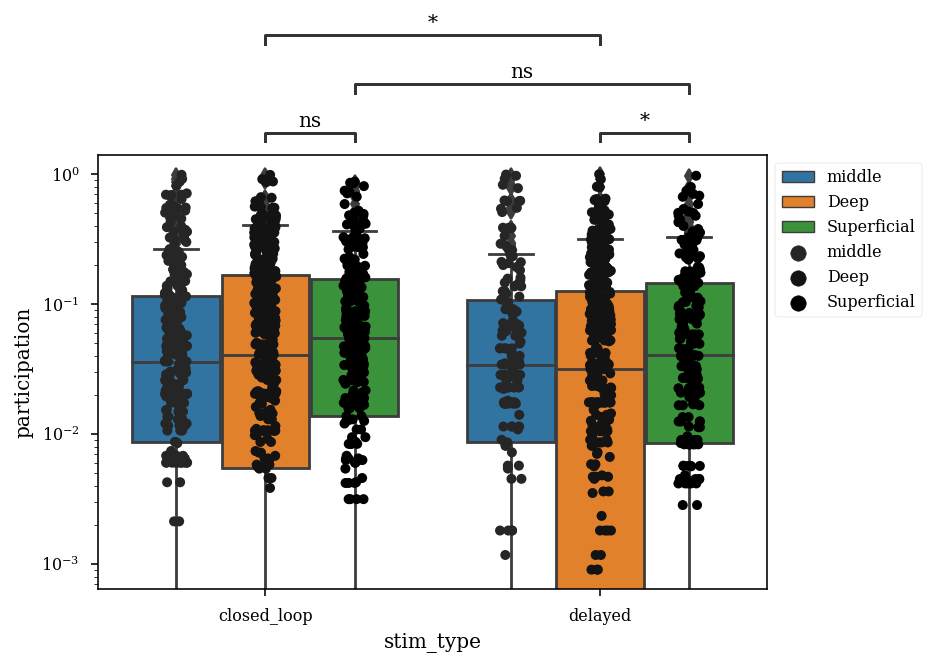

In [189]:
from statannotations.Annotator import Annotator
sns.boxplot(x='stim_type',y='participation',hue="deepSuperficial",data=results)
sns.stripplot(x='stim_type',y='participation',hue="deepSuperficial",data=results,dodge=True,color="black")
plt.yscale('log')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
box_pairs = [
    (("closed_loop", "Deep"),("closed_loop", "Superficial")),
    (("delayed", "Deep"),("delayed", "Superficial")),
    (("closed_loop", "Deep"),("delayed", "Deep")),
    (("closed_loop", "Superficial"),("delayed", "Superficial")),
]
annotator = Annotator(
    plt.gca(),
    box_pairs,
    data=results,
    x="stim_type",
    y="participation",
    hue="deepSuperficial"
)
annotator.configure(
    test="Mann-Whitney",
    text_format="star",
    loc="outside",
    comparisons_correction=None,
    verbose=0,
)
annotator.apply_and_annotate()
plt.show()

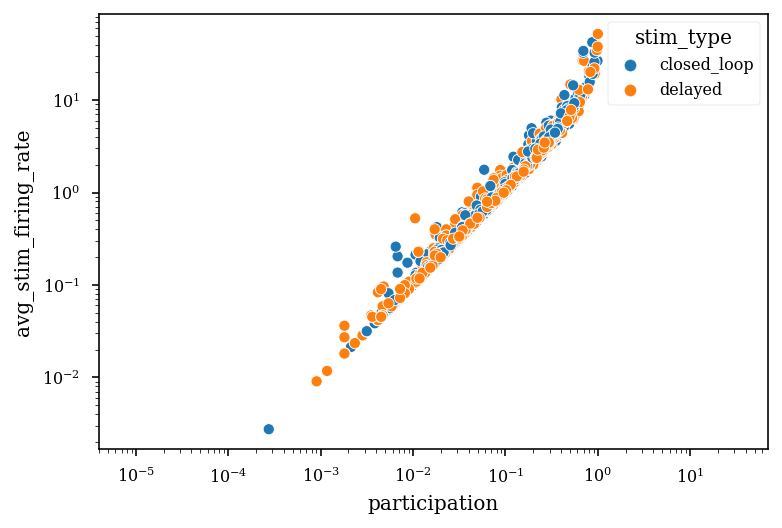

In [191]:
sns.scatterplot(x='participation',y='avg_stim_firing_rate',hue="stim_type",data=results)
plt.axis("equal")
plt.yscale('log')
plt.xscale('log')

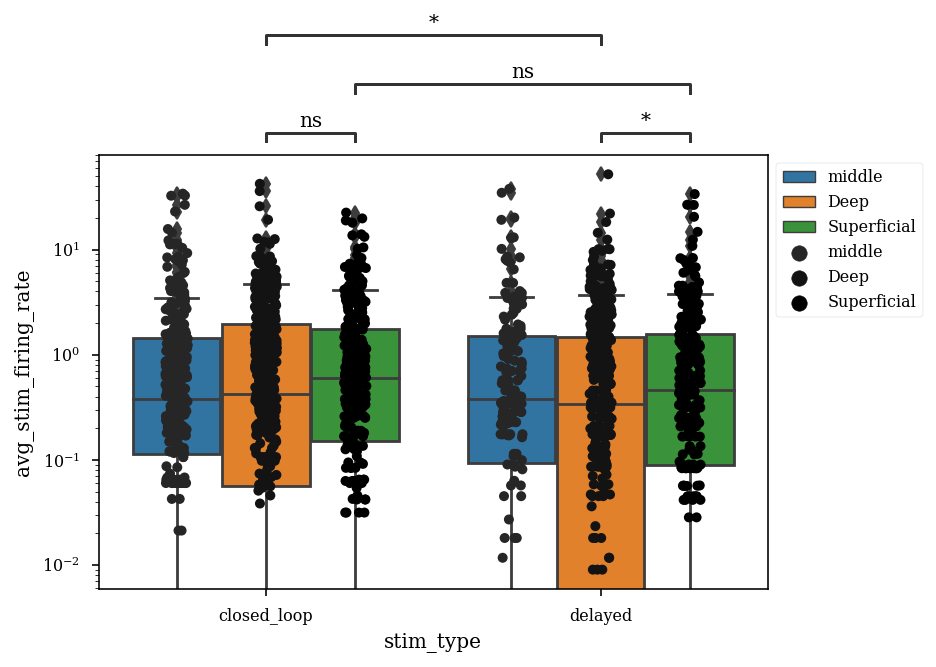

In [192]:
sns.boxplot(x='stim_type',y='avg_stim_firing_rate',hue="deepSuperficial",data=results)
sns.stripplot(x='stim_type',y='avg_stim_firing_rate',hue="deepSuperficial",data=results,dodge=True,color="black")
plt.yscale('log')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

box_pairs = [
    (("closed_loop", "Deep"),("closed_loop", "Superficial")),
    (("delayed", "Deep"),("delayed", "Superficial")),
    (("closed_loop", "Deep"),("delayed", "Deep")),
    (("closed_loop", "Superficial"),("delayed", "Superficial")),
]
annotator = Annotator(
    plt.gca(),
    box_pairs,
    data=results,
    x="stim_type",
    y="avg_stim_firing_rate",
    hue="deepSuperficial"
)
annotator.configure(
    test="Mann-Whitney",
    text_format="star",
    loc="outside",
    comparisons_correction=None,
    verbose=0,
)
annotator.apply_and_annotate()
plt.show()


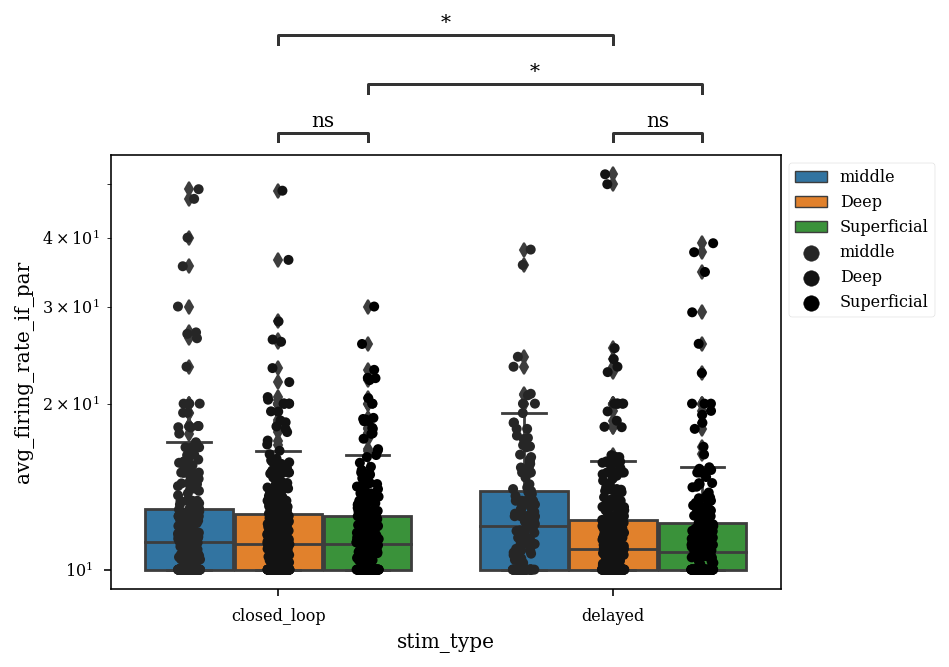

In [193]:
sns.boxplot(x='stim_type',y='avg_firing_rate_if_par',hue="deepSuperficial",data=results)
sns.stripplot(x='stim_type',y='avg_firing_rate_if_par',hue="deepSuperficial",data=results,dodge=True,color="black")
plt.yscale('log')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

box_pairs = [
    (("closed_loop", "Deep"),("closed_loop", "Superficial")),
    (("delayed", "Deep"),("delayed", "Superficial")),
    (("closed_loop", "Deep"),("delayed", "Deep")),
    (("closed_loop", "Superficial"),("delayed", "Superficial")),
]
annotator = Annotator(
    plt.gca(),
    box_pairs,
    data=results,
    x="stim_type",
    y="avg_firing_rate_if_par",
    hue="deepSuperficial"
)
annotator.configure(
    test="Mann-Whitney",
    text_format="star",
    loc="outside",
    comparisons_correction=None,
    verbose=0,
)
annotator.apply_and_annotate()
plt.show()


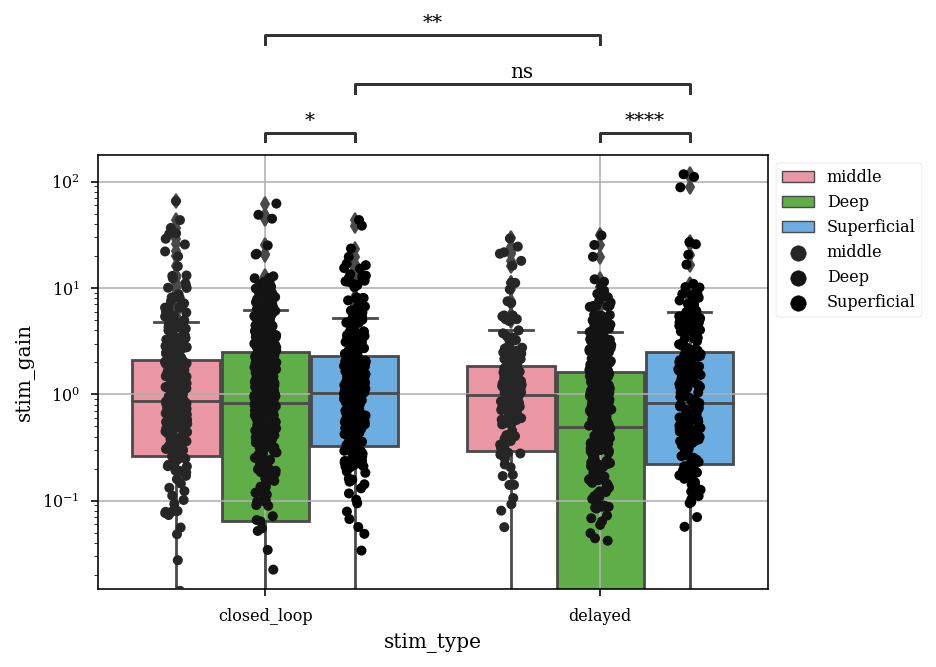

In [264]:
sns.boxplot(x='stim_type',y='stim_gain',hue="deepSuperficial",data=results)
sns.stripplot(x='stim_type',y='stim_gain',hue="deepSuperficial",data=results,dodge=True,color="black")
plt.yscale('log')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

box_pairs = [
    (("closed_loop", "Deep"),("closed_loop", "Superficial")),
    (("delayed", "Deep"),("delayed", "Superficial")),
    (("closed_loop", "Deep"),("delayed", "Deep")),
    (("closed_loop", "Superficial"),("delayed", "Superficial")),
]
annotator = Annotator(
    plt.gca(),
    box_pairs,
    data=results,
    x="stim_type",
    y="stim_gain",
    hue="deepSuperficial"
)
annotator.configure(
    test="Mann-Whitney",
    text_format="star",
    loc="outside",
    comparisons_correction=None,
    verbose=0,
)
annotator.apply_and_annotate()
plt.grid()
plt.show()


In [274]:
manipulation_epochs[manipulation_epochs.ev_label == "closed_loop"]

,start,stop,peaks,center,duration,amplitude,amplitudeUnits,ev_label
0,3.41255,3.51255,3.46255,3.46255,0.1,NaN,au,closed_loop
1,10.43515,10.53515,10.48515,10.48515,0.1,NaN,au,closed_loop
2,22.50845,22.60845,22.55845,22.55845,0.1,NaN,au,closed_loop
3,34.28070,34.38070,34.33070,34.33070,0.1,NaN,au,closed_loop
4,37.22515,37.32515,37.27515,37.27515,0.1,NaN,au,closed_loop
...,...,...,...,...,...,...,...,...
4747,21327.19765,21327.29765,21327.24765,21327.24765,0.1,NaN,au,closed_loop
4748,21366.13200,21366.23200,21366.18200,21366.18200,0.1,NaN,au,closed_loop
4749,21491.72590,21491.82590,21491.77590,21491.77590,0.1,NaN,au,closed_loop
4750,21510.06840,21510.16840,21510.11840,21510.11840,0.1,NaN,au,closed_loop


In [275]:
psth = pd.DataFrame()
label_df = pd.DataFrame()
for basepath in df.basepath:
    manipulation_epochs = loading.load_manipulation(
        basepath, struct_name="optoStim", return_epoch_array=False
    )
    st, cm = loading.load_spikes(basepath, putativeCellType="Pyr", brainRegion="CA1")
    cm = add_new_deep_sup.deep_sup_from_deepSuperficialDistance(cm)

    for stim_type in manipulation_epochs.ev_label.unique():
        
        stim_epoch = nel.EpochArray([manipulation_epochs[manipulation_epochs.ev_label == stim_type][["start","stop"]].values])

        psth_temp = functions.compute_psth(
            st.data,
            stim_epoch.starts,
            bin_width=0.005,
            n_bins=100,
        )

        psth = pd.concat([psth, psth_temp], axis=1)

        temp_df = pd.DataFrame()
        temp_df["brainRegion"] = cm.brainRegion.values
        temp_df["deepSuperficial"] = cm.deepSuperficial.values
        temp_df["UID"] = cm.UID.values
        temp_df["stim_type"] = stim_type
        temp_df["basepath"] = basepath

        label_df = pd.concat([label_df, temp_df], axis=0, ignore_index=True)


In [196]:
label_df.shape, psth.shape

((1987, 5), (101, 1987))

In [276]:
label_df["n_stim_type"] = label_df.basepath.map(
    label_df.groupby("basepath")
    .stim_type.apply(lambda x: x.nunique())
    .reset_index()
    .set_index("basepath")["stim_type"]
    .to_dict()
)
label_df


,brainRegion,deepSuperficial,UID,stim_type,basepath,n_stim_type
0,CA1,middle,1,closed_loop,Z:\Data\ORproject\OR15\day1,1
1,CA1,Deep,2,closed_loop,Z:\Data\ORproject\OR15\day1,1
2,CA1,middle,4,closed_loop,Z:\Data\ORproject\OR15\day1,1
3,CA1,middle,5,closed_loop,Z:\Data\ORproject\OR15\day1,1
4,CA1,middle,6,closed_loop,Z:\Data\ORproject\OR15\day1,1
...,...,...,...,...,...,...
1982,CA1sp,middle,83,delayed,Z:\Data\ORproject\OR15\hc300118,2
1983,CA1sp,Deep,84,delayed,Z:\Data\ORproject\OR15\hc300118,2
1984,CA1sr,middle,85,delayed,Z:\Data\ORproject\OR15\hc300118,2
1985,CA1sp,Deep,86,delayed,Z:\Data\ORproject\OR15\hc300118,2


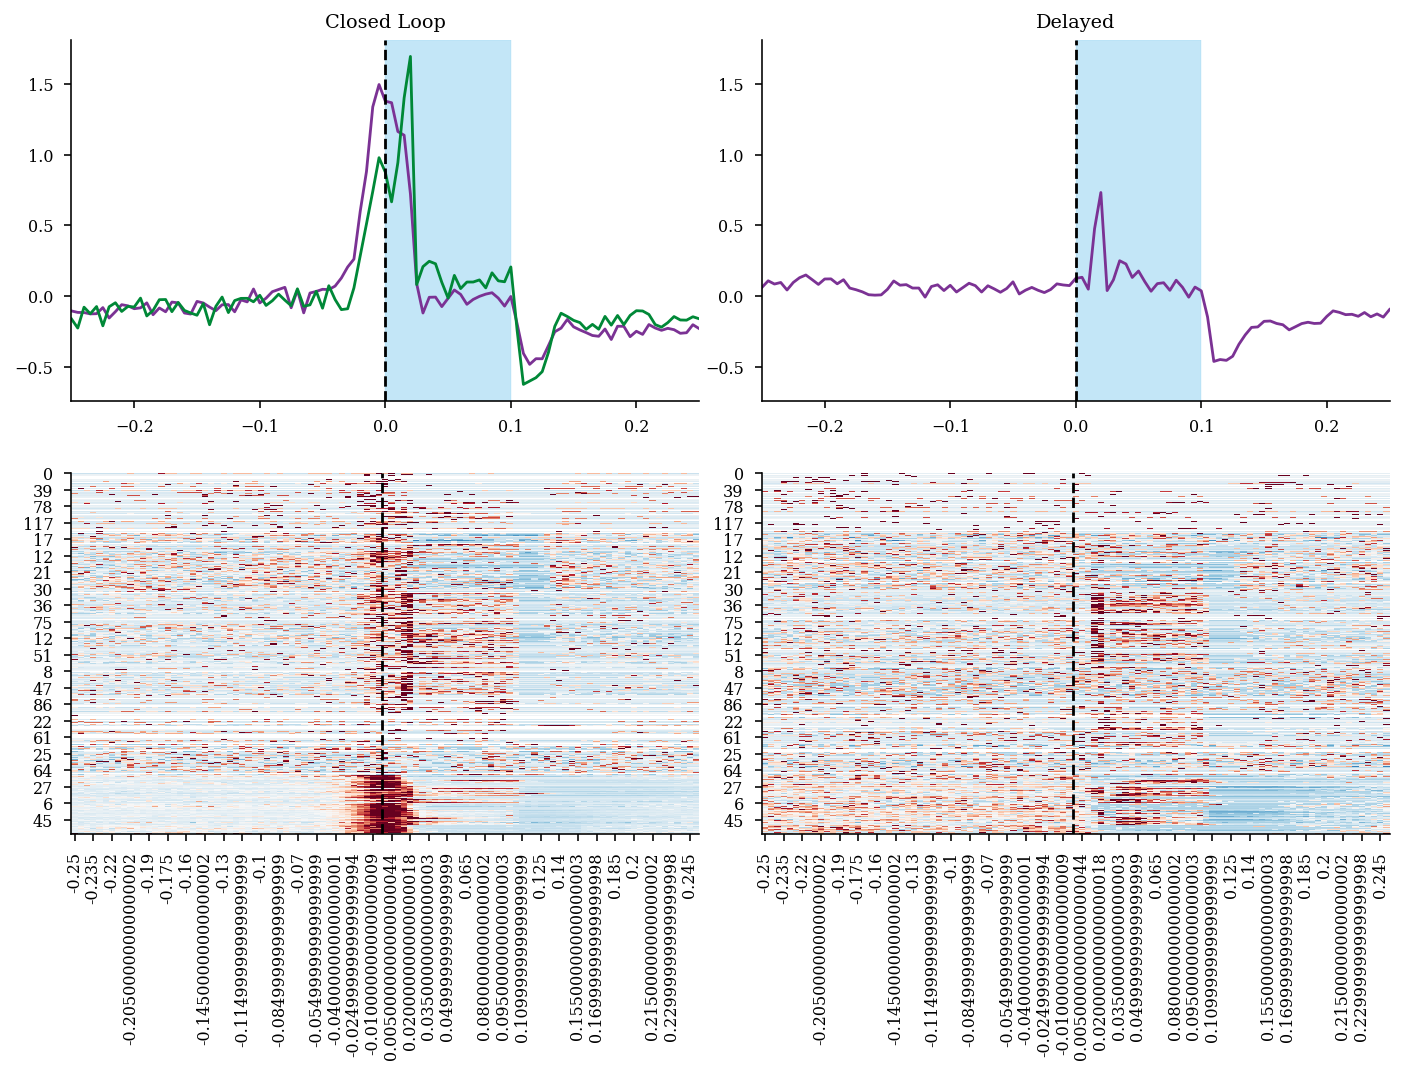

In [207]:
group_colors = {"Deep": "#7b3294", "Superficial": "#008837"}
sns.set_palette(sns.color_palette(group_colors.values()))

fig, axs = plt.subplots(
    2,
    2,
    figsize=functions.set_size("thesis", fraction=2, subplots=(2, 2)),
    sharex=False,
)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
axs = axs.ravel()

axs[0].plot(
    stats.zscore(
        psth.iloc[
            :,
            (
                (label_df.stim_type == "closed_loop")
                & (label_df.n_stim_type == 2)
                & (label_df.deepSuperficial == "Deep")
            ).values,
        ]
    ).mean(axis=1),
    label="closed_loop",
    color=group_colors["Deep"],
)

axs[0].plot(
    stats.zscore(
        psth.iloc[
            :,
            (
                (label_df.stim_type == "closed_loop")
                & (label_df.n_stim_type == 2)
                & (label_df.deepSuperficial == "Superficial")
            ).values,
        ]
    ).mean(axis=1),
    label="closed_loop",
    color=group_colors["Superficial"],
)

sns.heatmap(
    stats.zscore(
        psth.iloc[
            :,
            (
                (label_df.stim_type == "closed_loop") & (label_df.n_stim_type == 2)
            ).values,
        ],
        axis=0,
    ).T,
    cmap="RdBu_r",
    vmin=-3,
    vmax=3,
    ax=axs[2],
    cbar=False,
)

axs[1].plot(
    stats.zscore(psth.iloc[:, ((label_df.stim_type == "delayed") & (label_df.n_stim_type == 2)).values]).mean(axis=1),
    label="delayed",
)
sns.heatmap(
    stats.zscore(psth.iloc[:, ((label_df.stim_type == "delayed") & (label_df.n_stim_type == 2)).values], axis=0).T,
    cmap="RdBu_r",
    vmin=-3,
    vmax=3,
    ax=axs[3],
    cbar=False,
)

axs[0].axvspan(0, 0.1, color="#89CFF0", alpha=0.5)
axs[1].axvspan(0, 0.1, color="#89CFF0", alpha=0.5)

axs[0].set_xlim(psth.index.min(), psth.index.max())
axs[1].set_xlim(psth.index.min(), psth.index.max())

axs[0].axvline(0, color="black", linestyle="--")
axs[1].axvline(0, color="black", linestyle="--")
axs[2].axvline(np.where(psth.index == 0)[0], color="black", linestyle="--", zorder=1000)
axs[3].axvline(np.where(psth.index == 0)[0], color="black", linestyle="--", zorder=1000)

axs[0].set_title("Closed Loop")
axs[1].set_title("Delayed")

axs[1].sharey(axs[0])
# ax1.sharey(ax3)

sns.despine()
plt.show()


In [226]:

def plot_psth_matrix(psth_df, label=None, ax=None, vmax=3, vmin=-3):

    psth = psth_df.values

    # psth_smooth = gaussian_filter1d(psth, np.round(.020 / np.diff(psth_df.index)[0]),axis=0)
    psth_smooth = psth

    if ax is None:
        plt.figure()
        ax = plt.gca()

    extent = [psth_df.index.min(), psth_df.index.max(), 0, psth.shape[1]]

    sm = ax.imshow(
        stats.zscore(psth_smooth, axis=0).T,
        aspect="auto",
        interpolation="nearest",
        extent=extent,
        vmin=vmin,
        vmax=vmax,
        cmap="bwr"
    )

    ax.set_yticks([psth.shape[1]])

    ax.axvline(0, color="k", lw=1, ls="--")
    if label is not None:
        ax.set_title(label, fontsize=12)
    return sm

def confidence_intervals(X, conf=0.95):
    # remove nans
    X = X[np.sum(np.isnan(X), axis=1) == 0, :]
    # compute interval for each column
    interval = [
        stats.t.interval(conf, len(a) - 1, loc=np.mean(a), scale=stats.sem(a))
        for a in X.T
    ]
    interval = np.vstack(interval)
    lower = interval[:, 0]
    upper = interval[:, 1]
    return lower, upper

def plot_shaded_line(psth_df,group_colors,group_label,ax0, zscore=True):
    psth = psth_df.values
    if zscore:
        psth = stats.zscore(psth, axis=0)
    lower, upper = confidence_intervals(psth.T)
    ax0.plot(
        psth_df.index,
        np.nanmean(psth, axis=1),
        color=group_colors[group_label],
        linewidth=1,
    )
    ax0.fill_between(
        psth_df.index,
        lower,
        upper,
        color=group_colors[group_label],
        alpha=0.5,
        linewidth=0,
    )

In [278]:
df

,basepath,basename
Var1,,
212,Z:\Data\ORproject\OR15\day1,day1
213,Z:\Data\ORproject\OR15\day10,day10
214,Z:\Data\ORproject\OR15\day2,day2
215,Z:\Data\ORproject\OR15\day3,day3
216,Z:\Data\ORproject\OR15\day4,day4
217,Z:\Data\ORproject\OR18\day1,day1
218,Z:\Data\ORproject\OR18\day2,day2
219,Z:\Data\ORproject\OR18\day3,day3
220,Z:\Data\ORproject\OR21\day2,day2


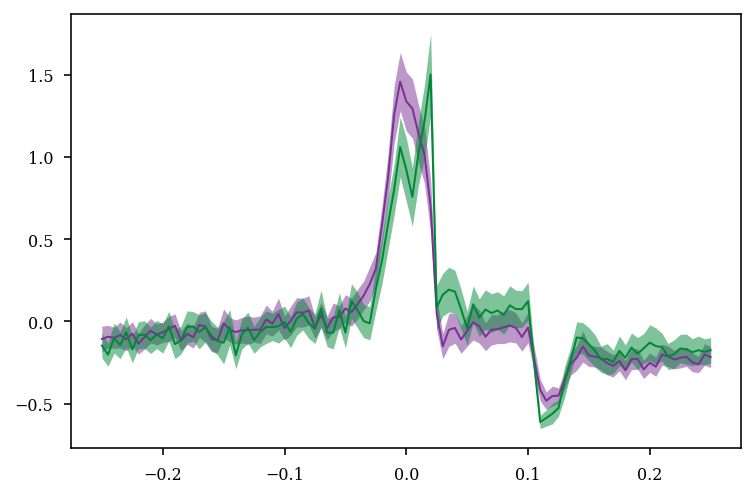

In [277]:
plt.figure()
ax = plt.gca()
idx = (
    (label_df.stim_type == "closed_loop")
    & (label_df.deepSuperficial == "Deep")
).values
# time_idx = (psth.index > -.1) & (psth.index < .2)
plot_shaded_line(psth.iloc[:, idx],group_colors,"Deep",ax)

idx = (
    (label_df.stim_type == "closed_loop")
    & (label_df.deepSuperficial == "Superficial")
).values
plot_shaded_line(psth.iloc[:, idx],group_colors,"Superficial",ax)


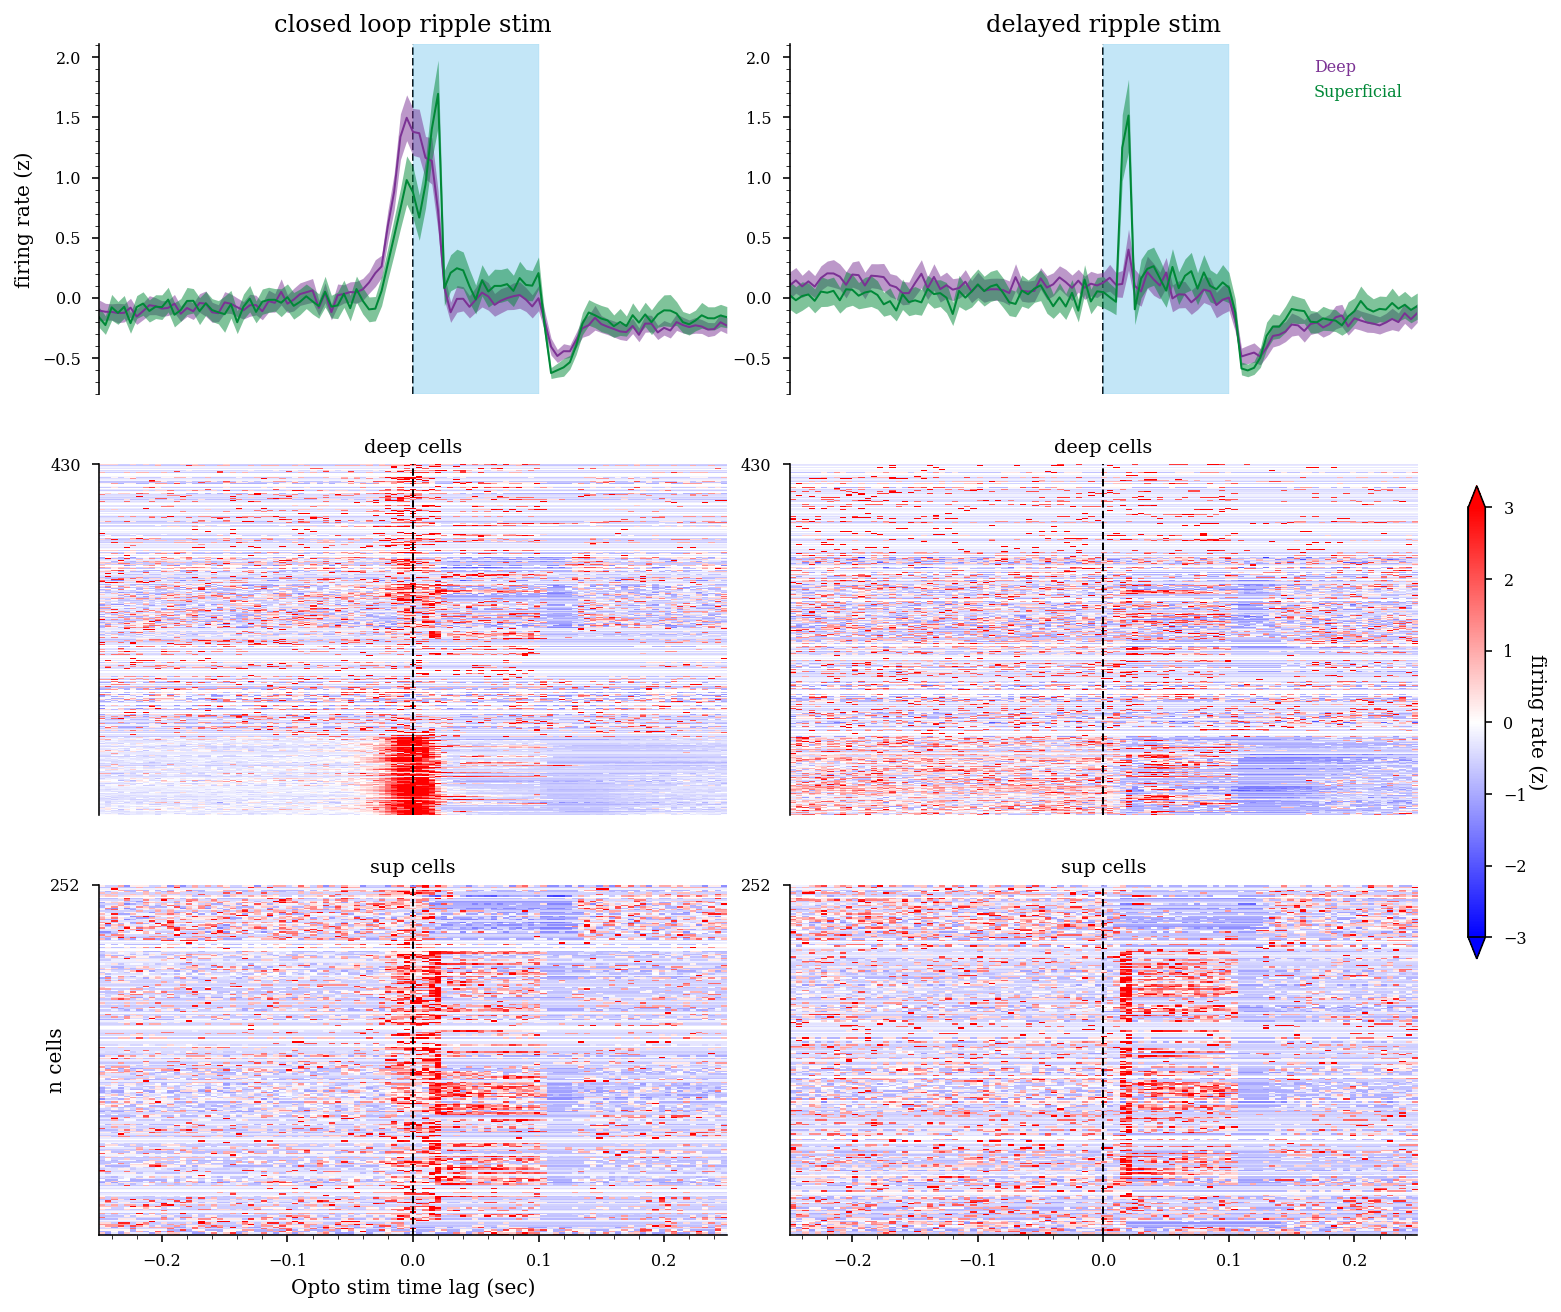

In [262]:
# plot_psth_matrix(psth_df, cell_metrics, region_idx, label=None, ax=None, vmax=3, vmin=-3)

group_colors = {"Deep": "#7b3294", "Superficial": "#008837"}
sns.set_palette(sns.color_palette(group_colors.values()))

fig, axs = plt.subplots(3,2,
    figsize=functions.set_size("thesis", fraction=2, subplots=(3, 2)),
    sharex=False,
)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
axs = axs.ravel()

idx = (
    (label_df.stim_type == "closed_loop")
    & (label_df.n_stim_type == 2)
    & (label_df.deepSuperficial == "Deep")
).values
plot_shaded_line(psth.iloc[:, idx],group_colors,"Deep",axs[0])
plot_psth_matrix(psth.iloc[:, idx], ax=axs[2])

idx = (
    (label_df.stim_type == "closed_loop")
    & (label_df.n_stim_type == 2)
    & (label_df.deepSuperficial == "Superficial")
).values
plot_shaded_line(psth.iloc[:, idx],group_colors,"Superficial",axs[0])
sm = plot_psth_matrix(psth.iloc[:, idx], ax=axs[4])



idx = (
    (label_df.stim_type == "delayed")
    & (label_df.n_stim_type == 2)
    & (label_df.deepSuperficial == "Deep")
).values
plot_shaded_line(psth.iloc[:, idx],group_colors,"Deep",axs[1])
plot_psth_matrix(psth.iloc[:, idx], ax=axs[3])

idx = (
    (label_df.stim_type == "delayed")
    & (label_df.n_stim_type == 2)
    & (label_df.deepSuperficial == "Superficial")
).values
plot_shaded_line(psth.iloc[:, idx],group_colors,"Superficial",axs[1])
plot_psth_matrix(psth.iloc[:, idx], ax=axs[5])

axs[0].set_title("closed loop ripple stim",fontsize=12)
axs[1].set_title("delayed ripple stim",fontsize=12)
axs[2].set_title("deep cells")
axs[3].set_title("deep cells")
axs[4].set_title("sup cells")
axs[5].set_title("sup cells")

axs[1].sharey(axs[0])
axs[0].set_xlim(psth.index.min(), psth.index.max())
axs[1].set_xlim(psth.index.min(), psth.index.max())

cax = plt.axes([.93, 0.3, 0.01, 0.3])
cbar = plt.colorbar(sm,cax=cax, extend='both')
cbar.set_label('firing rate (z)', rotation=270, labelpad=10)

axs[0].axvline(0, color="black", linestyle="--",lw=1,zorder=-1000)
axs[1].axvline(0, color="black", linestyle="--",lw=1,zorder=-1000)

axs[0].axvspan(0, 0.1, color="#89CFF0", alpha=0.5,zorder=-1000)
axs[1].axvspan(0, 0.1, color="#89CFF0", alpha=0.5,zorder=-1000)

axs[0].set_ylabel('firing rate (z)')
axs[4].set_xlabel('Opto stim time lag (sec)')
axs[4].set_ylabel('n cells',labelpad=-8)

for ax in axs:
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())

sns.despine()
for i in range(4):
    axs[i].spines["bottom"].set_visible(False)
    axs[i].axes.get_xaxis().set_ticks([])
    

axs[1].legend(["Deep","Superficial"],labelcolor=group_colors.values(),loc="upper right",handlelength=0, handletextpad=0,frameon=False)    

plt.savefig(
    os.path.join(fig_save_path, "ripple_closed_loop_deep_sup_psth.jpeg"),
    dpi=300,
    bbox_inches="tight",
)

In [186]:
basepath = r"Z:\Data\ORproject\OR15\hc300118"
manipulation_epochs = loading.load_manipulation(
    basepath, struct_name="optoStim", return_epoch_array=False
)
st, cm = loading.load_spikes(basepath, putativeCellType="Pyr", brainRegion="CA1")
cm = add_new_deep_sup.deep_sup_from_deepSuperficialDistance(cm)
# manipulation_epochs,st

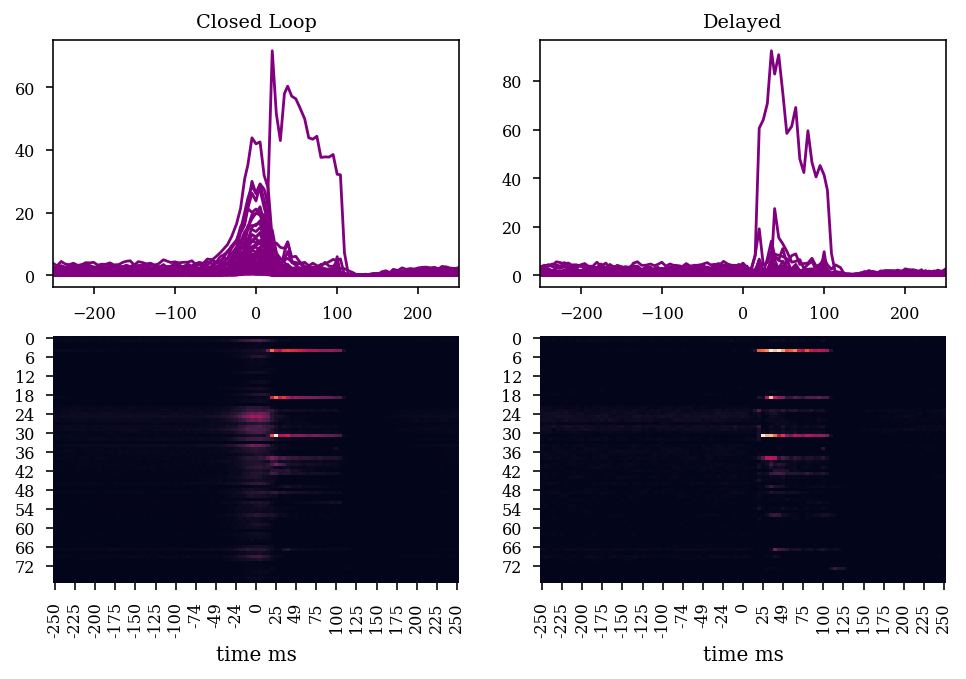

In [187]:
fig,ax = plt.subplots(2,2,figsize=(8,5))

closed_loop_psth = functions.compute_psth(st.data, manipulation_epochs[manipulation_epochs.ev_label == "closed_loop"].start.values, bin_width=0.005, n_bins=100)
closed_loop_psth.index = (closed_loop_psth.index*1000).astype(int)
closed_loop_psth.index.rename("time ms", inplace=True)

delayed_psth = functions.compute_psth(st.data, manipulation_epochs[manipulation_epochs.ev_label == "delayed"].start.values, bin_width=0.005, n_bins=100)
delayed_psth.index = (delayed_psth.index*1000).astype(int)
delayed_psth.index.rename("time ms", inplace=True)

ax[0,0].plot(closed_loop_psth.index,closed_loop_psth.iloc[:,cm.deepSuperficial.values=="Deep"],color="purple")
ax[0,0].plot(closed_loop_psth.index,closed_loop_psth.iloc[:,cm.deepSuperficial.values=="Superficial"],color="green")

# closed_loop_psth.plot(legend=False,ax=ax[0,0])
sns.heatmap(closed_loop_psth.T,ax=ax[1,0],cbar=False)

ax[0,1].plot(delayed_psth.index,delayed_psth.iloc[:,cm.deepSuperficial.values=="Deep"],color="purple")
ax[0,1].plot(delayed_psth.index,delayed_psth.iloc[:,cm.deepSuperficial.values=="Superficial"],color="green")

sns.heatmap(delayed_psth.T,ax=ax[1,1],cbar=False)

ax[0,0].set_xlim(closed_loop_psth.index.min(),closed_loop_psth.index.max())
ax[0,1].set_xlim(delayed_psth.index.min(),delayed_psth.index.max())

ax[0,0].set_title("Closed Loop")
ax[0,1].set_title("Delayed")
plt.show()

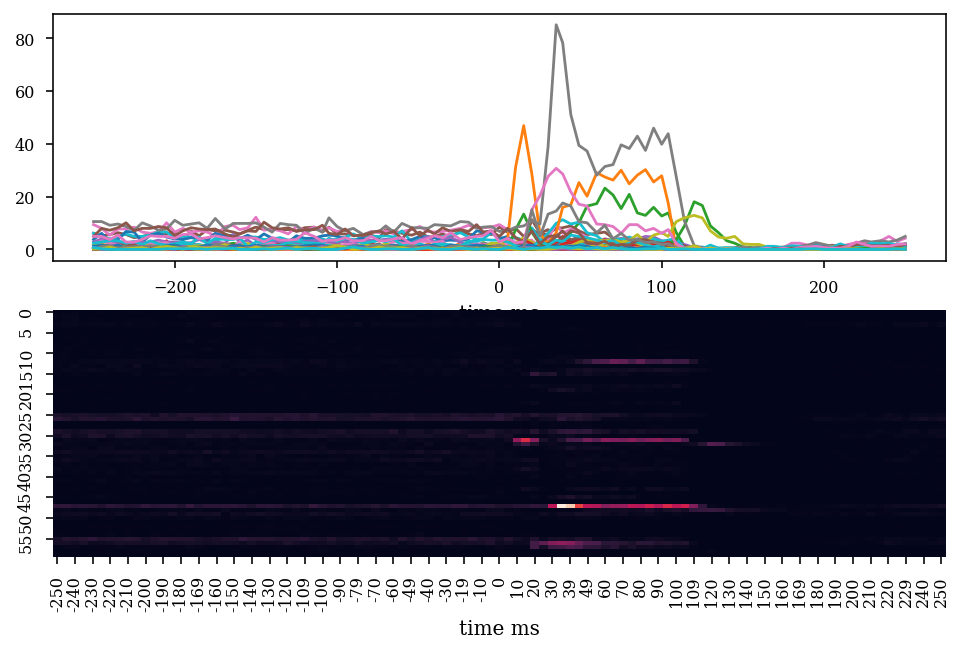

In [64]:
delayed_psth = functions.compute_psth(st.data, manipulation_epochs["delayed"].starts, bin_width=0.005, n_bins=100)
delayed_psth.index = (delayed_psth.index*1000).astype(int)
delayed_psth.index.rename("time ms", inplace=True)

fig,ax = plt.subplots(2,1,figsize=(8,5))
delayed_psth.plot(legend=False,ax=ax[0])
sns.heatmap(delayed_psth.T,ax=ax[1],cbar=False)
plt.show()

## testing below

In [4]:
manipulation_epochs = loading.load_manipulation(
    basepath, struct_name="optoStim",return_epoch_array=False
)

display(manipulation_epochs)

manipulation_epochs = loading.load_manipulation(
    basepath, struct_name="optoStim",return_epoch_array=True
)

display(manipulation_epochs)

,start,stop,peaks,center,duration,amplitude,amplitudeUnits,ev_label
0,3.41255,3.51255,3.46255,3.46255,0.1,NaN,au,closed_loop
1,10.43515,10.53515,10.48515,10.48515,0.1,NaN,au,closed_loop
2,22.50845,22.60845,22.55845,22.55845,0.1,NaN,au,closed_loop
3,34.28070,34.38070,34.33070,34.33070,0.1,NaN,au,closed_loop
4,37.22515,37.32515,37.27515,37.27515,0.1,NaN,au,closed_loop
...,...,...,...,...,...,...,...,...
4747,21327.19765,21327.29765,21327.24765,21327.24765,0.1,NaN,au,delayed
4748,21366.13200,21366.23200,21366.18200,21366.18200,0.1,NaN,au,delayed
4749,21491.72590,21491.82590,21491.77590,21491.77590,0.1,NaN,au,delayed
4750,21510.06840,21510.16840,21510.11840,21510.11840,0.1,NaN,au,delayed


{'closed_loop': <EpochArray at 0x19a4851fb20: 3,646 epochs> of length 6:04:600 minutes,
 'delayed': <EpochArray at 0x19a4851fac0: 1,106 epochs> of length 1:50:600 minutes}

In [5]:
st,cm = loading.load_spikes(basepath,putativeCellType="Pyr",brainRegion="CA1")
cm = add_new_deep_sup.deep_sup_from_deepSuperficialDistance(cm)


In [6]:
fr_mat = functions.get_participation(st.data,manipulation_epochs['closed_loop'].starts, manipulation_epochs['closed_loop'].stops,par_type="binary")

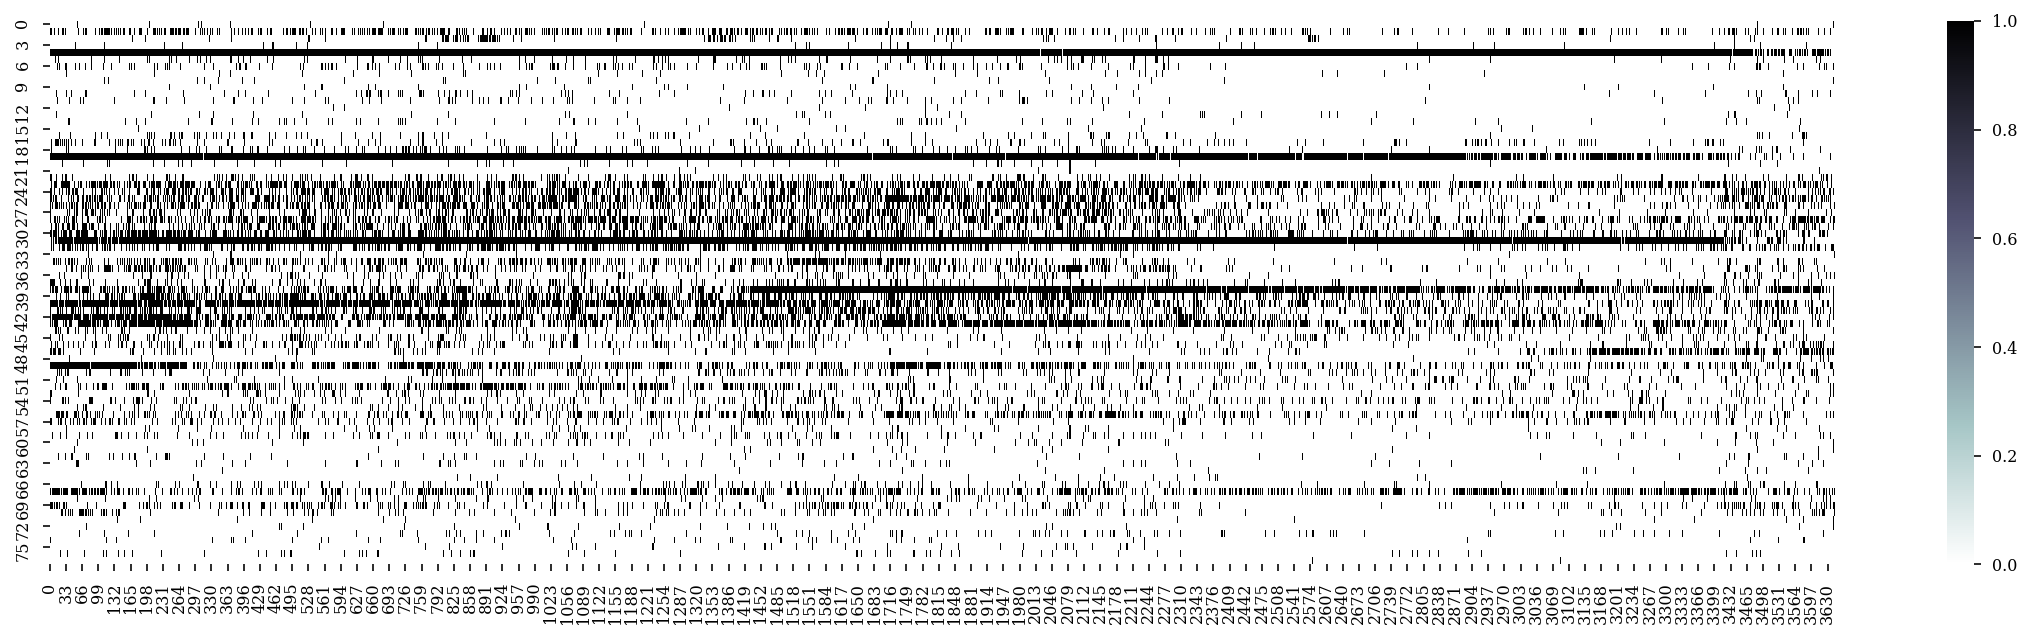

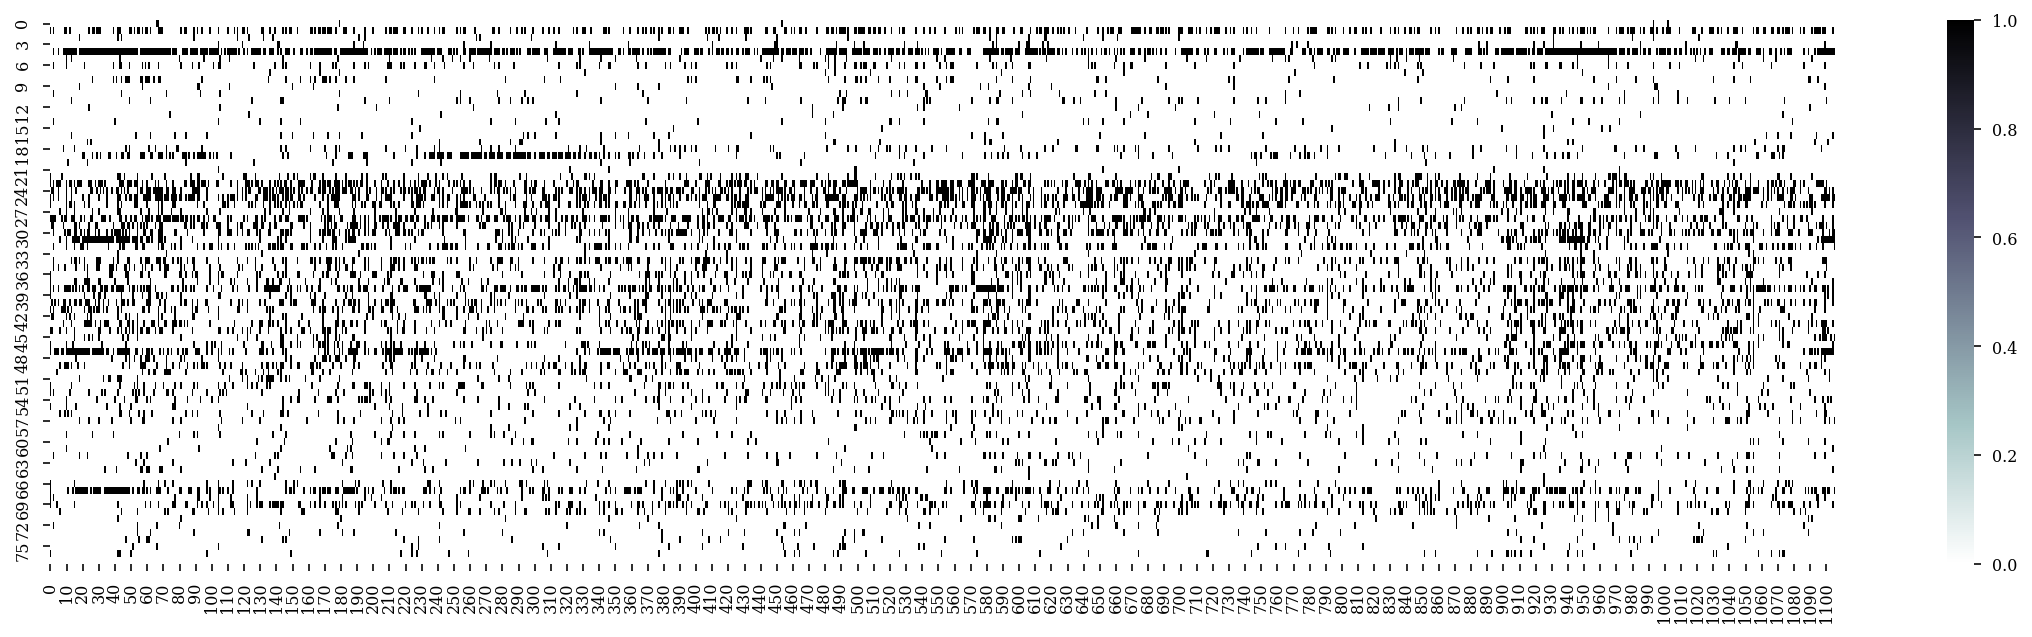

In [7]:
closed_loop = functions.get_participation(st.data,manipulation_epochs['closed_loop'].starts, manipulation_epochs['closed_loop'].stops,par_type="binary")
plt.figure(figsize=(20,5))
sns.heatmap(closed_loop,cmap="bone_r")
plt.show()

delayed = functions.get_participation(st.data,manipulation_epochs['delayed'].starts, manipulation_epochs['delayed'].stops,par_type="binary")
plt.figure(figsize=(20,5))
sns.heatmap(delayed,cmap="bone_r")
plt.show()

In [8]:
df = pd.DataFrame()
df['participation'] = np.hstack([closed_loop.mean(axis=1),delayed.mean(axis=1)])
df['stim_type'] = np.hstack([np.repeat('closed_loop',closed_loop.shape[0]),np.repeat('delayed',delayed.shape[0])])
df['deepSuperficial'] = np.hstack([cm.deepSuperficial,cm.deepSuperficial])
df['deepSuperficialDistance'] = np.hstack([cm.deepSuperficialDistance,cm.deepSuperficialDistance])

df

,participation,stim_type,deepSuperficial,deepSuperficialDistance
0,0.006308,closed_loop,Deep,-145.736540
1,0.271530,closed_loop,Deep,-165.686232
2,0.052386,closed_loop,middle,-28.817655
3,0.016731,closed_loop,Deep,-195.604452
4,0.978881,closed_loop,Deep,-145.604452
...,...,...,...,...
151,0.038879,delayed,middle,-28.817655
152,0.036166,delayed,Deep,-115.736540
153,0.028029,delayed,middle,11.182345
154,0.046112,delayed,Deep,-155.604452


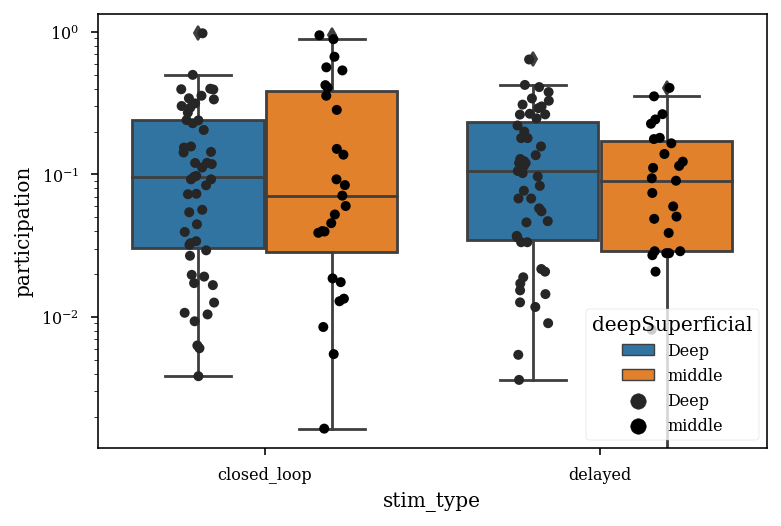

In [11]:
sns.boxplot(x='stim_type',y='participation',hue="deepSuperficial",data=df)
sns.stripplot(x='stim_type',y='participation',hue="deepSuperficial",data=df,dodge=True,color="black")
plt.yscale('log')

<AxesSubplot:xlabel='deepSuperficialDistance', ylabel='participation'>

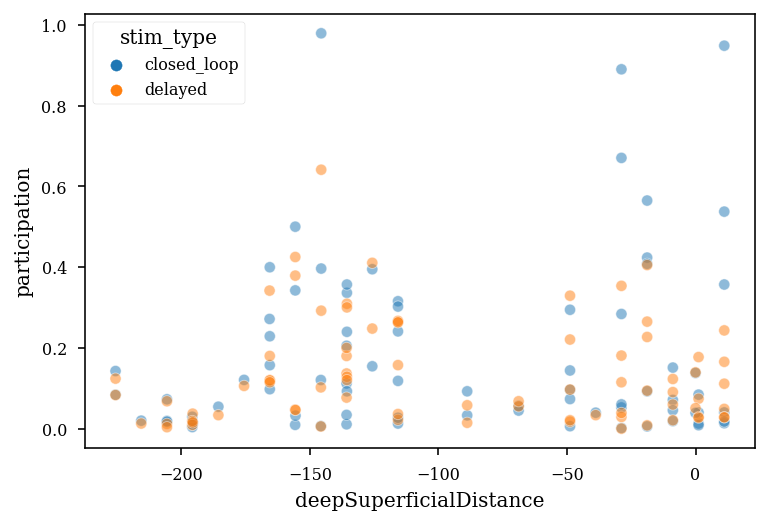

In [10]:
sns.scatterplot(x='deepSuperficialDistance',y='participation',hue='stim_type',data=df,alpha=0.5)

(0.0, 1.0)

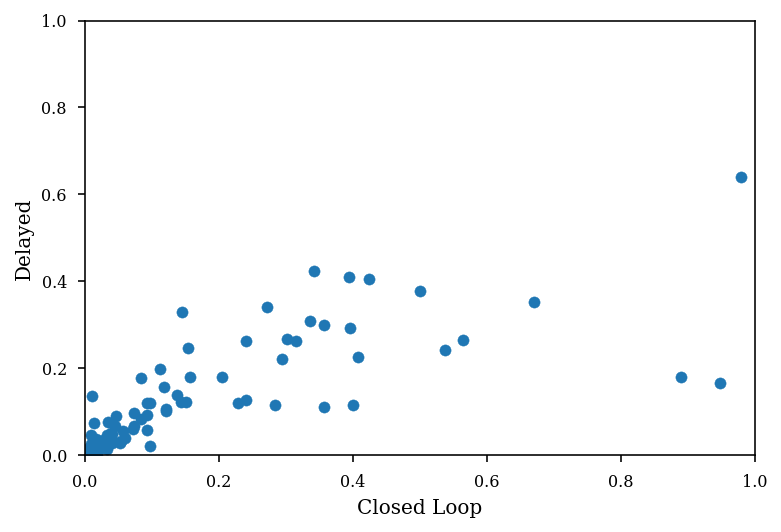

In [104]:
plt.scatter(closed_loop.mean(axis=1),delayed.mean(axis=1))
plt.xlabel("Closed Loop")
plt.ylabel("Delayed")
plt.xlim([0,1])
plt.ylim([0,1])

In [ ]:
pearson = np.corrcoef(closed_loop,delayed)

sns.heatmap(pearson,cmap="RdBu_r",vmin=-.5,vmax=.5)